## Spatial Data Science : Street Network Analysis 

### How centrality metrics influence typology of business activities in the city of San Francisco

In [1]:
# import all libraries needed 
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx, pandas as pd
from IPython.display import Image
%matplotlib inline
ox.config(log_console=True, use_cache=True)
import scipy as sp

In [2]:
# Import distinctiveness package
from distinctiveness.dc import distinctiveness

### Step 1 - Open Dataset Registerd Companies San Francisco  

#### Aerial Image San Francisco Map
![title](img/aerial_image.png)

In [3]:
# open csv downloaded from San Francisco Open Data
df_buss = pd.read_csv('registered_business_sanfra.csv', low_memory=False)
df_buss.head()

,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,...,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,DELETE - Zip Codes,DELETE - Fire Prevention Districts,DELETE - Supervisor Districts,DELETE - Current Police Districts,DELETE - Neighborhoods,DELETE - Police Districts
0,0404143-01-999,404143,Gepsr Llc,Entertainment Partners,Po Box 7837,Burbank,CA,91510.0,08/30/2006,02/21/2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1121337-09-161,1058392,"Bash, Inc.","Bash, Inc.",764 54th St.,Oakland,CA,94609.0,09/28/2016,09/30/2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1122247-10-161,1058834,Edgar Barrero,Edgar Barrero,5466 Roundtree Dr A,Concord,CA,94521.0,05/25/2016,05/30/2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1145483-05-171,1069805,Elmer Bungay,Elmer Bungay,517 Heath St,Milpitas,CA,95035.0,05/05/2017,05/05/2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1107771-08-161,1051654,Uber,Uber,414 A St,Daly City,CA,94014.0,01/01/2016,07/31/2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# extract specific columns needed 
df_buss_2 = df_buss[['Location Id', 'DBA Name','Street Address', 'City', 'NAICS Code Description','Business Location']]
df_buss_2.head()

,Location Id,DBA Name,Street Address,City,NAICS Code Description,Business Location
0,0404143-01-999,Entertainment Partners,Po Box 7837,Burbank,NaN,NaN
1,1121337-09-161,"Bash, Inc.",764 54th St.,Oakland,NaN,NaN
2,1122247-10-161,Edgar Barrero,5466 Roundtree Dr A,Concord,NaN,NaN
3,1145483-05-171,Elmer Bungay,517 Heath St,Milpitas,NaN,NaN
4,1107771-08-161,Uber,414 A St,Daly City,NaN,NaN


In [22]:
# drop all rows with nan values in the columns 'NAICS Code Description' and 'Business Location'
df_buss_3 = df_buss_2[df_buss_2['NAICS Code Description'].notna()]
df_buss_4 = df_buss_3[df_buss_3['Business Location'].notna()]
df_buss_4

,Location Id,DBA Name,Street Address,City,NAICS Code Description,Business Location
356,0000422-01-001,Adler Kurt S Inc,680 Eighth Street 157,San Francisco,Wholesale Trade,POINT (-122.404476 37.770475)
358,0000484-01-001,Agid Hyman D,452 Gellert Dr,San Francisco,"Professional, Scientific, and Technical Services",POINT (-122.48987 37.730494)
359,0000553-01-001,Akron Meat Market,3325 20th St,San Francisco,Wholesale Trade,POINT (-122.415292 37.758859)
367,0001520-01-001,Arrow Paper Co,750 18th St,San Francisco,Wholesale Trade,POINT (-122.390399 37.762955)
368,0001520-02-001,Fast Impressions,750 18th St,San Francisco,Wholesale Trade,POINT (-122.390399 37.762955)
...,...,...,...,...,...,...
194799,1078936-06-161,Arallon Properties,482 Bryant St,San Francisco,Real Estate and Rental and Leasing Services,POINT (-122.39547 37.781611)
194800,1078950-06-161,182 Stanyan Street,1519 27th Avenue Ave,San Francisco,Real Estate and Rental and Leasing Services,POINT (-122.485415 37.75904)
194801,1078954-06-161,Sean Higgins,80 Venus St,San Francisco,Accommodations,POINT (-122.397482 37.731625)
194802,1078960-06-161,Geli,657 Mission St Ste 500,San Francisco,"Professional, Scientific, and Technical Services",POINT (-122.40107 37.787005)


#### Visualizing registered businesses in San Francisco (92693)
![title](img/all_business_SanFrancisco.png)

#### a) Classify all different categories of businesses 

In [17]:
# undestrand the number of different categories in the dataset
# count values in the dataframe
df_buss_4['NAICS Code Description'].value_counts()

Real Estate and Rental and Leasing Services         17891
Professional, Scientific, and Technical Services    16120
Construction                                         9792
Retail Trade                                         9036
Food Services                                        6925
Private Education and Health Services                5051
Arts, Entertainment, and Recreation                  4780
Transportation and Warehousing                       3447
Accommodations                                       3026
Financial Services                                   2809
Certain Services                                     2738
Wholesale Trade                                      2496
Information                                          2440
Administrative and Support Services                  2138
Multiple                                             1913
Manufacturing                                        1418
Insurance                                             498
Utilities     

In [23]:
# this for loop iterate over the dataframe and make a classification according to the type of the business category

category = [] 
for value in df_buss_4["NAICS Code Description"]: 
    if value == 'Real Estate and Rental and Leasing Services': 
        category.append(1) 
    elif value == 'Professional, Scientific, and Technical Services':
        category.append(2)
    elif value == 'Construction':
        category.append(3) 
    elif value == 'Retail Trade':
        category.append(4) 
    elif value == 'Food Services':
        category.append(5) 
    elif value == 'Private Education and Health Services':
        category.append(6) 
    elif value == 'Arts, Entertainment, and Recreation':
        category.append(7) 
    elif value == 'Transportation and Warehousing':
        category.append(8) 
    elif value == 'Accommodations':
        category.append(9) 
    elif value == 'Financial Services':
        category.append(10) 
    elif value == 'Certain Services':
        category.append(11)
    elif value == 'Wholesale Trade':
        category.append(12)
    elif value == 'Information':
        category.append(13)
    elif value == 'Administrative and Support Services':
        category.append(14)
    elif value == 'Multiple':
        category.append(15)
    elif value == 'Manufacturing':
        category.append(16)
    elif value == 'Insurance':
        category.append(17)
    elif value == 'Utilities':
        category.append(18)             
    else: 
        category.append("fail") 

# add new column to the dataframe 
df_buss_4["Result"] = category
# print first five lines of the dataset
df_buss_4.head(10)

C:\Anaconda\envs\Street_Networks\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Location Id,DBA Name,Street Address,City,NAICS Code Description,Business Location,Result
356,0000422-01-001,Adler Kurt S Inc,680 Eighth Street 157,San Francisco,Wholesale Trade,POINT (-122.404476 37.770475),12
358,0000484-01-001,Agid Hyman D,452 Gellert Dr,San Francisco,"Professional, Scientific, and Technical Services",POINT (-122.48987 37.730494),2
359,0000553-01-001,Akron Meat Market,3325 20th St,San Francisco,Wholesale Trade,POINT (-122.415292 37.758859),12
367,0001520-01-001,Arrow Paper Co,750 18th St,San Francisco,Wholesale Trade,POINT (-122.390399 37.762955),12
368,0001520-02-001,Fast Impressions,750 18th St,San Francisco,Wholesale Trade,POINT (-122.390399 37.762955),12
379,0002142-01-001,Balboa Pet Hospital,3329 Balboa St,San Francisco,"Arts, Entertainment, and Recreation",POINT (-122.49441 37.77584),7
381,0002270-01-001,Barbic James F Tax Consultant,1801 Van Ness Ave 300,San Francisco,"Professional, Scientific, and Technical Services",POINT (-122.422821 37.792366),2
382,0002289-01-001,Dryden Margoles Etal,555 Montgomery St 750,San Francisco,"Professional, Scientific, and Technical Services",POINT (-122.403102 37.794454),2
384,0002826-01-001,Bryson Lawrence D Md,450 Sutter St #1723,San Francisco,"Professional, Scientific, and Technical Services",POINT (-122.407788 37.789331),2
385,0002826-02-001,Travel Health Medical Center,450 Sutter St #1723,San Francisco,"Professional, Scientific, and Technical Services",POINT (-122.407788 37.789331),2


#### Visualizing businesses by category in San Francisco (92693)
![title](img/business_SanFrancisco_categorized_post.png)

In [16]:
# export dataset in csv
df_buss_4.to_csv('buss_sanfra_categorized.csv')

### Step 2 - Export Street Network (San Francisco)

#### a) Theoretical Framework

#### Source - Zachary Neal : The Connected City (fig. 5.3 'two approaches to mapping street networks')
![title](img/two_approaches_street_network.png)

#### b) Create Street Network using OSMnx library (by Geoff Boeing Director USC Urban Data Lab)

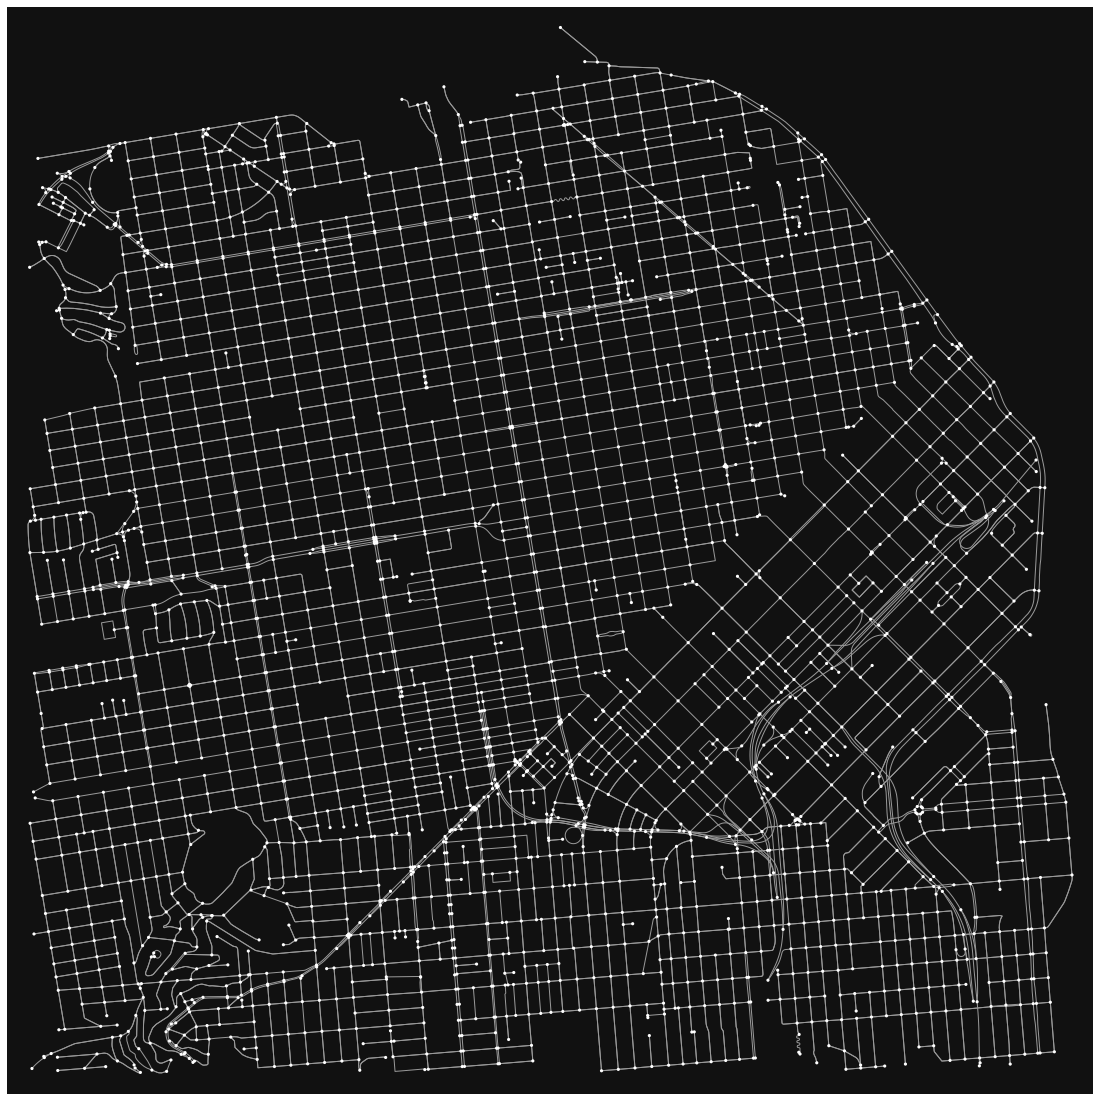

In [19]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.7842, -122.4197)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G2 = ox.graph_from_point(location_point, dist=3000, dist_type='bbox', network_type='drive')
G2 = ox.project_graph(G2)
fig, ax = ox.plot_graph(G2, node_size=10, node_color='white', figsize=(20,20))

### Step 3 - Calculate Nodes Centrality Measures

In [20]:
# save street network as ESRI shapefile to work with in GIS
# specify filepath to create a folder
ox.save_graph_shapefile(G2, filepath='./shape_exported/shape_4')
G2

#### a) Calculation Distinctiveness Centrality

##### Which node has more distinctive connections ? 
$D_{1}(i)$ = $\sum_{j=1}^{n} w_{ij} log_{10} \frac{n - 1}{g_{j}^{a}}$

In [26]:
#Calculate the 5 metrics of Distinctiveness Centrality
DC = distinctiveness(G2, normalize = False, alpha = 1, measures=["D1"])
DC = pd.DataFrame(DC).sort_index()
DC.head()

MultiDiGraph converted to DiGraph


,D1_in,D1_out
32927563,6.634482,3.467756
33241803,6.333452,6.333452
33242031,2.990635,2.990635
54891208,8.846966,9.023057
54891395,8.846966,8.846966


#### b) Calculation Degree Centrality

##### How many nodes can be reached directly ? 
##### Formula : $C_{d}(v_{i})$ = $\frac{deg(v_{i})}{g - 1}$

In [27]:
# perform degree centrality for the network 
dgc = nx.degree_centrality(G2)
# turn dictionary into dataframe
df_dgc = pd.DataFrame.from_dict(dgc, orient='index', columns=['degree_centrality']).sort_index()

In [28]:
df_dgc.head()

,degree_centrality
32927563,0.001022
33241803,0.001362
33242031,0.000681
54891208,0.002044
54891395,0.002044


#### c) Calculation Closeness Centrality

##### How fast can a social actor reach the others ? 
##### Formula : $C_{c}(v_{i})$ = $\frac{g - 1}{\sum_{j=1}^{g} d(v_{i},v_{j}) }$

In [29]:
# this line calculates closness centrality 
dcc = nx.closeness_centrality(G2)
# turn dictionary into dataframe
df_dcc = pd.DataFrame.from_dict(dcc, orient='index', columns=['closeness_centrality']).sort_index()

In [30]:
df_dcc.head()

,closeness_centrality
32927563,0.040789
33241803,0.029996
33242031,0.031077
54891208,0.027880
54891395,0.028385


#### d) Calculation Eigenvector Centrality

In [31]:
dec = nx.eigenvector_centrality_numpy(G2)
# turn dictionary into dataframe
df_dec = pd.DataFrame.from_dict(dec, orient='index', columns=['eigenvector_centrality']).sort_index()

In [32]:
df_dec.head()

,eigenvector_centrality
32927563,2.823451e-14
33241803,1.361462e-08
33242031,3.642895e-05
54891208,-4.226568e-17
54891395,-5.453433e-17


#### e) Combine All Centrality Measures

In [33]:
final_df = pd.concat([df_dgc, df_dcc, df_dec, DC['D1_in']], axis=1, sort=False)
final_df.head()

,degree_centrality,closeness_centrality,eigenvector_centrality,D1_in
32927563,0.001022,0.040789,2.823451e-14,6.634482
33241803,0.001362,0.029996,1.361462e-08,6.333452
33242031,0.000681,0.031077,3.642895e-05,2.990635
54891208,0.002044,0.027880,-4.226568e-17,8.846966
54891395,0.002044,0.028385,-5.453433e-17,8.846966


In [59]:
# save file in csv 
final_df.to_csv('nodes_metrics_business_sanfra_fixed_finaltry.csv')

### Step 4 - Join operation in QGIS

#### Join Operation and Final Attribute Table 
![title](img/workflow_join.png)

![title](img/workflow_join_2.png)

### Step 5 - Visualize Degree Centrality and Closeness Centrality 

#### Visualizing Degree Centrality Distribution 
![title](img/degree_centrality.png)

#### Visualizing Closeness Centrality Distribution
![title](img/closeness_centrality.png)

### Step 6 - Filter nodes with highest Degree and Closeness Centrality

In [34]:
# open dataset with centrality and nodes coordinates exported from Qgis 
full_dataset = pd.read_csv('nodes_coordinates_centrality_full.csv', low_memory=False)
full_dataset.head()

,y,x,osmid,lon,lat,highway,ref,field_1,degree_centrality,closeness_centrality,eigenvector_centrality,D1_in
0,4.184382e+06,550429.500571,65298435,-122.427127,37.805431,NaN,NaN,65298435,0.002044,0.027481,6.760092e-05,9.324087
1,4.180975e+06,552455.956762,65290249,-122.404355,37.774608,NaN,NaN,65290249,0.001022,0.037865,3.533712e-16,6.333452
2,4.180939e+06,552420.297137,65290251,-122.404762,37.774286,traffic_signals,NaN,65290251,0.001362,0.036579,8.337135e-17,6.032422
3,4.180891e+06,552372.578414,65290252,-122.405308,37.773855,NaN,NaN,65290252,0.001362,0.033392,2.881708e-17,6.634482
4,4.182500e+06,552085.590900,5828476940,-122.408451,37.788377,crossing,NaN,5828476940,0.001703,0.037578,1.966243e-09,9.147996


In [35]:
# extract specific columns needed 
full_dataset = full_dataset[['osmid', 'lon','lat', 'degree_centrality', 'closeness_centrality','eigenvector_centrality', 'D1_in']]

In [36]:
# print first five lines
full_dataset.head()

,osmid,lon,lat,degree_centrality,closeness_centrality,eigenvector_centrality,D1_in
0,65298435,-122.427127,37.805431,0.002044,0.027481,6.760092e-05,9.324087
1,65290249,-122.404355,37.774608,0.001022,0.037865,3.533712e-16,6.333452
2,65290251,-122.404762,37.774286,0.001362,0.036579,8.337135e-17,6.032422
3,65290252,-122.405308,37.773855,0.001362,0.033392,2.881708e-17,6.634482
4,5828476940,-122.408451,37.788377,0.001703,0.037578,1.966243e-09,9.147996


#### a) Select nodes with highest degree centrality 

In [37]:
# filter nodes with degree centrality bigger than 0.00259
full_dataset_high_centrality = full_dataset.loc[full_dataset['degree_centrality'] >= 0.00259]
full_dataset_high_centrality.head()

,osmid,lon,lat,degree_centrality,closeness_centrality,eigenvector_centrality,D1_in
11,65290286,-122.410494,37.765609,0.002725,0.032354,-1.166457e-17,11.587723
14,65290291,-122.410383,37.764309,0.002725,0.031506,-1.290873e-16,11.587723
15,65290294,-122.410263,37.763038,0.002725,0.030614,-2.071855e-16,11.587723
16,65290296,-122.410141,37.761765,0.002725,0.029769,-2.356565e-16,11.462784
17,65290299,-122.410014,37.760494,0.002725,0.028918,-1.667068e-16,11.587723


In [73]:
# export in csv to visualize it in Qgis 
full_dataset_high_centrality.to_csv('nodes_highest_degree_centrality.csv')

#### b) Create round buffer (aroound 60 meters diameter) in Qgis 

#### Visualizing Nodes with Highest Degree Centrality with buffer of around 60 meters
![title](img/highest_degree_centrality_buffer.png)

#### c) Select nodes with highest Closeness centrality 

In [38]:
# filter nodes with degree centrality bigger than 0.0354
full_dataset_high_closeness = full_dataset.loc[full_dataset['closeness_centrality'] >= 0.0354]
full_dataset_high_closeness.head()

,osmid,lon,lat,degree_centrality,closeness_centrality,eigenvector_centrality,D1_in
1,65290249,-122.404355,37.774608,0.001022,0.037865,3.533712e-16,6.333452
2,65290251,-122.404762,37.774286,0.001362,0.036579,8.337135e-17,6.032422
4,5828476940,-122.408451,37.788377,0.001703,0.037578,1.966243e-09,9.147996
6,65290257,-122.406566,37.772864,0.001362,0.035772,3.323371e-16,6.634482
7,65290263,-122.409139,37.770824,0.001362,0.036285,8.986336e-16,6.157361


In [39]:
# export in csv to visualize it in Qgis 
full_dataset_high_closeness.to_csv('nodes_highest_closeness_centrality.csv')

#### d) Create round buffer (60 meters diameter) in Qgis 

#### Visualizing Nodes with Highest Closness Centrality with buffer of around 60 meters
![title](img/highest_closeness_centrality_buffer.png)

### Step 7 - Join Businesses Spatial Attributes with Buffers Highest Centrality

#### a) Operate Join by Attributes in Qgis combining the buffers created and the businesses locations

#### Join by location 
![title](img/join_location_by_attributes.png)

#### Attribute table that represents the result of the join by location 
![title](img/table_full_byCategory.png)

#### Each osmid has all the businesses 60 meters around it
![title](img/filter_byosmid.png)

#### b) Categorize new layer coloring it with the majority of business category in it 

#### Using an expression to count the majority of business typologies within the buffer 
![title](img/categorize_byBusiness_category.png)

### Step 8 - Observe if centrality measures are related to business categories

#### Visualizing Majority of Businesses Categories within Buffers Highest Degree Centrality
![title](img/highest_degree_centrality_withBusinesses.png)

#### Visualizing Majority of Businesses Categories within Buffers Highest Closeness Centrality
![title](img/highest_closeness_centrality_withBusinesses.png)

### Step 9 - Filtering Most Frequent Business Categories to Explore for other Patterns 

#### Visualizing Majority of Businesses Categories within Buffers Highest Degree Centrality (excluding category 1 and 2)
![title](img/highest_degree_centrality_withBusinesses_lessFrequent.png)

#### Visualizing Majority of Businesses Categories within Buffers Highest Closeness Centrality (excluding category 1 and 2)
![title](img/highest_closeness_centrality_withBusinesses_lessFrequent.png)